## TODO

Try PCA on the full table and color based on the class/annotation

In [83]:
import pandas as pd
import numpy as np
import keras
from sklearn.preprocessing import Imputer
from keras.utils import to_categorical
import sys

    
def prepare_input_df(data, is_training=True):    
    data.index = range(0, len(data))
    data = data.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

    # Make dummy variables for annotation
    one_hot_data = pd.concat([data, pd.get_dummies(data['Pclass'], prefix='Pclass'), pd.get_dummies(data['Sex'], prefix='Sex'), pd.get_dummies(data['Embarked'], prefix='Embarked') ], axis=1)

    # Drop the previous rank column
    one_hot_data = one_hot_data.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

    one_hot_data[:10]
    data = one_hot_data

    # imputing missing values
    data.loc[~data['Cabin'].isnull(), ['Cabin']] = 1
    data.loc[data['Cabin'].isnull(), ['Cabin']] = 0
    
    data.loc[data['Age'].isnull(), ['Age']] = data['Age'].max()
    

    ## replace YES with 1 and NO with 0 and store to 'y'
    # label_mapping = {'YES': 1, 'NO': 0}
    # data = data.replace({'Survived': label_mapping})

    if is_training:
        y = data['Survived']
        
    # normalise data
    data = (data - data.min()) / (data.max() - data.min())

    # imputing missing values
    # fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
    # imputed_DF = pd.DataFrame(fill_NaN.fit_transform(data))
    # imputed_DF.columns = data.columns
    # data.index = data.index
    # data = imputed_DF
    # data = data.interpolate(method='spline', order=2) # interpolate missing values
    #data = data.fillna(0)

    if is_training:
        data['Survived'] = y
    
    return data

data = pd.read_csv('train.csv', sep=',')
data = prepare_input_df(data)

data[:10]

# test = pd.read_csv('test.csv', sep=',')
# test_data = prepare_input_df(test, False)
# test_data[:10]



,Survived,Age,SibSp,Parch,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,0.271174,0.125,0.000000,0.014151,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,0.472229,0.125,0.000000,0.139136,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,0.321438,0.000,0.000000,0.015469,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1,0.434531,0.125,0.000000,0.103644,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,0.434531,0.000,0.000000,0.015713,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
5,0,1.000000,0.000,0.000000,0.016510,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6,0,0.673285,0.000,0.000000,0.101229,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7,0,0.019854,0.375,0.166667,0.041136,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
8,1,0.334004,0.000,0.333333,0.021731,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
9,1,0.170646,0.125,0.000000,0.058694,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [74]:
np.random.seed(3)

# # Split X into training and test sets
# sample = np.random.choice(data.index, size=int(len(data)*0.7), replace=False)
# train_data, test_data = data.iloc[sample], data.drop(sample)

# train using all rows from train.csv
train_data = data

print("Number of training samples is", len(train_data))
# print("Number of testing samples is", len(test_data))

Number of training samples is 891


In [75]:
X_train = np.array(train_data.drop('Survived', axis=1))
y_train = np.array(keras.utils.to_categorical(train_data['Survived'], 2))

# X_test = np.array(test_data.drop('Survived', axis=1))
# y_test = np.array(keras.utils.to_categorical(test_data['Survived'], 2))


print("Number of rows in X_train: ", len(X_train))
print("Number of rows in y_train: ", len(y_train))
# print("Number of rows in X_test", len(X_test))
# print("Number of rows in y_test", len(y_test))

Number of rows in X_train:  891
Number of rows in y_train:  891


In [56]:
data.columns
# tt = pd.DataFrame(y_train)
# tt.columns = ['c0', 'c1']
# tt.loc[tt['c1'] == 1.0]
# data
X_train.shape

(891, 13)

### Build Neural Network with `sckit-learn` wrapper for `Keras`

In [76]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras import regularizers
from keras.metrics import categorical_accuracy
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(init_mode='he_normal'):
    
    reglr = 0.0001
    # Building the model
    model = Sequential()
    # model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(512, kernel_initializer=init_mode, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(reglr) ))
    model.add(Dropout(.4))
    # model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, kernel_initializer=init_mode, activation='relu', kernel_regularizer=regularizers.l2(reglr)))
    model.add(Dropout(.2))
    # model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    # model.add(Dropout(.1))
    # model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    # model.add(Dropout(.2))
    # model.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    # model.add(Dropout(.1))
    model.add(Dense(2, activation='softmax'))

    # Compiling the model
    # sgd_optim = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
    # adam=keras.optimizers.Adam(lr=0.00001)
          
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)
# model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
model

### Grid Search for optimal Training Optimisation Algorithm - [ DONE ]

In [ ]:
# Define the grid search parameters

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

param_grid = dict(optimizer=optimizer)

# Run grid search
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, n_jobs=1)

grid_tuning = grid.fit(X_train, y_train)

#### Results from optimizer tuning

In [244]:
print("Best: %f using %s" % (grid_tuning.best_score_, grid_tuning.best_params_))
means = grid_tuning.cv_results_['mean_test_score']
stds = grid_tuning.cv_results_['std_test_score']
params = grid_tuning.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.808081 using {'optimizer': 'Adam'}
0.805836 (0.007936) with: {'optimizer': 'SGD'}
0.802469 (0.010408) with: {'optimizer': 'RMSprop'}
0.808081 (0.004762) with: {'optimizer': 'Adagrad'}
0.808081 (0.007274) with: {'optimizer': 'Adadelta'}
0.808081 (0.011983) with: {'optimizer': 'Adam'}
0.803591 (0.011446) with: {'optimizer': 'Adamax'}
0.806958 (0.015141) with: {'optimizer': 'Nadam'}


<br/><br/>

### Grid Search for optimal learning rate, momentum and number of epochs

In [ ]:
# Define the grid search parameters

# learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
# param_grid = dict(lr=learn_rate, momentum=momentum)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)

batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode, batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_tuning = grid.fit(X_train, y_train)

#### Results from optimizer tuning

In [283]:
print("Best: %f using %s" % (grid_tuning.best_score_, grid_tuning.best_params_))
means = grid_tuning.cv_results_['mean_test_score']
stds = grid_tuning.cv_results_['std_test_score']
params = grid_tuning.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.806958 using {'init_mode': 'he_normal'}
0.803591 (0.013561) with: {'init_mode': 'uniform'}
0.802469 (0.019309) with: {'init_mode': 'lecun_uniform'}
0.802469 (0.019888) with: {'init_mode': 'normal'}
0.616162 (0.033445) with: {'init_mode': 'zero'}
0.804714 (0.012598) with: {'init_mode': 'glorot_normal'}
0.803591 (0.014108) with: {'init_mode': 'glorot_uniform'}
0.806958 (0.004199) with: {'init_mode': 'he_normal'}
0.802469 (0.006919) with: {'init_mode': 'he_uniform'}


<br/><br/><br/><br/><br/><br/><br/>

## Train model using optimal parameters

In [20]:
# # # Split X into training and test sets
# sample = np.random.choice(data.index, size=int(len(data)*0.7), replace=False)
# train_data, test_data = data.iloc[sample], data.drop(sample)

# X_train = np.array(train_data.drop('Survived', axis=1))
# y_train = np.array(keras.utils.to_categorical(train_data['Survived'], 2))

# X_test = np.array(test_data.drop('Survived', axis=1))
# y_test = np.array(keras.utils.to_categorical(test_data['Survived'], 2))

In [77]:
# Creating the model
model = create_model()

# Training the model
# callbacks = [EarlyStopping(monitor='acc', patience=2)] # do not apply without checking
out = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.1) #, callbacks=callbacks)

Train on 801 samples, validate on 90 samples
Epoch 1/100
801/801 [==============================] - 1s 656us/step - loss: 0.6096 - acc: 0.9220 - val_loss: 0.5864 - val_acc: 1.0000
Epoch 2/100
801/801 [==============================] - 0s 217us/step - loss: 0.5194 - acc: 1.0000 - val_loss: 0.4358 - val_acc: 1.0000
Epoch 3/100
801/801 [==============================] - 0s 248us/step - loss: 0.3115 - acc: 1.0000 - val_loss: 0.1832 - val_acc: 1.0000
Epoch 4/100
801/801 [==============================] - 0s 257us/step - loss: 0.1263 - acc: 1.0000 - val_loss: 0.0824 - val_acc: 1.0000
Epoch 5/100
801/801 [==============================] - 0s 281us/step - loss: 0.0734 - acc: 1.0000 - val_loss: 0.0612 - val_acc: 1.0000
Epoch 6/100
801/801 [==============================] - 0s 238us/step - loss: 0.0581 - acc: 1.0000 - val_loss: 0.0530 - val_acc: 1.0000
Epoch 7/100
801/801 [==============================] - 0s 267us/step - loss: 0.0511 - acc: 1.0000 - val_loss: 0.0474 - val_acc: 1.0000
Epoch 8/10

801/801 [==============================] - 0s 223us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 61/100
801/801 [==============================] - 0s 191us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 62/100
801/801 [==============================] - 0s 196us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 63/100
801/801 [==============================] - 0s 193us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 64/100
801/801 [==============================] - 0s 234us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 65/100
801/801 [==============================] - 0s 326us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 66/100
801/801 [==============================] - 0s 267us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 67/100
801/801 [==============================] - 0s 20

In [15]:
out.__dict__['history'].keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

/home/djifos/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


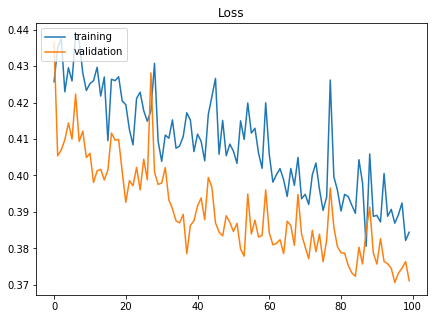

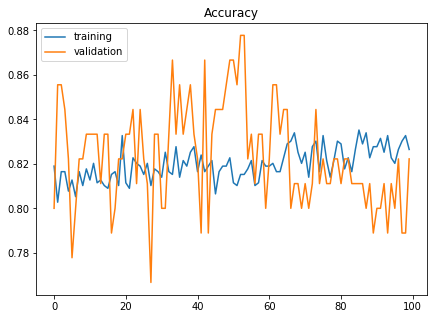

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = np.array(out.__dict__['epoch'])
acc = np.array(out.__dict__['history']['acc'])
loss = np.array(out.__dict__['history']['loss'])
val_acc = np.array(out.__dict__['history']['val_acc'])
val_loss = np.array(out.__dict__['history']['val_loss'])

f = plt.figure(figsize=(7,5))
plt.plot(epochs, loss, label='training')
plt.plot(epochs, val_loss, label='validation')
plt.legend(loc='upper left')
plt.title('Loss')

plt.show()

f = plt.figure(figsize=(7,5))
plt.plot(epochs, acc, label='training')
plt.plot(epochs, val_acc, label='validation')
plt.legend(loc='upper left')
plt.title('Accuracy')

plt.show()

f.savefig("train_validation_loss.pdf", bbox_inches='tight')

In [21]:
# Evaluating the model on the training and testing set
train_score = model.evaluate(X_train, y_train, verbose=1)
print("\n Training Accuracy:", train_score[1])
test_score = model.evaluate(X_test, y_test, verbose=1)
print("\n Testing Accuracy:", test_score[1])

623/623 [==============================] - 0s 58us/step

 Training Accuracy: 0.825040128507
268/268 [==============================] - 0s 67us/step

 Testing Accuracy: 0.873134329248


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
# y_pred = y.values.argmax

y_pred = model.predict_classes(X_test)

p = model.predict_proba(X_test)

print(classification_report(np.argmax(y_test, axis=1), y_pred))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))
print()
TN, FP, FN, TP = confusion_matrix(np.argmax(y_test, axis=1), y_pred).ravel()
print("TP:", TP)
print("FN:", FN)
print("TN:", TN)
print("FP:", FP)
len(p)

             precision    recall  f1-score   support

          0       0.88      0.95      0.91       185
          1       0.86      0.71      0.78        83

avg / total       0.87      0.87      0.87       268

[[175  10]
 [ 24  59]]

TP: 59
FN: 24
TN: 175
FP: 10


268

In [27]:
conc = pd.concat([pd.DataFrame(y_test), pd.DataFrame(p)], axis=1)
conc.columns = ['test_0', 'test_1', 'pred_0', 'pred_1']
subdf = conc.loc[conc['test_1'] == 1]
subdf.loc[subdf['pred_1'] >= 0.5][:5]

,test_0,test_1,pred_0,pred_1
2,0.0,1.0,0.462583,0.537417
3,0.0,1.0,0.004653,0.995347
8,0.0,1.0,0.479146,0.520854
11,0.0,1.0,0.140118,0.859882
16,0.0,1.0,0.000009,0.999991


In [78]:
test = pd.read_csv('test.csv', sep=',')
subm_test_data = prepare_input_df(test, False)

In [79]:
subm_test_data[:5]

y_pred = model.predict_classes(subm_test_data)
p = model.predict_proba(subm_test_data)
p[:10]

array([[  9.99990225e-01,   9.71680402e-06],
       [  9.99990225e-01,   9.71680402e-06],
       [  9.99990225e-01,   9.71680402e-06],
       [  9.99990225e-01,   9.71680402e-06],
       [  9.99990225e-01,   9.71680402e-06],
       [  9.99990225e-01,   9.71680402e-06],
       [  9.99990225e-01,   9.71680402e-06],
       [  9.99990225e-01,   9.71680402e-06],
       [  9.99990225e-01,   9.71680402e-06],
       [  9.99990225e-01,   9.71680402e-06]], dtype=float32)

In [80]:
df = pd.DataFrame(p)
df.columns = ['pred0', 'pred1']
df[:20]

,pred0,pred1
0,0.999990,0.000010
1,0.999990,0.000010
2,0.999990,0.000010
3,0.999990,0.000010
4,0.999990,0.000010
5,0.999990,0.000010
6,0.999990,0.000010
7,0.999990,0.000010
8,0.999990,0.000010
9,0.999990,0.000010


In [81]:
comp = df.pred0 < df.pred1
comp[:20]
type(comp)

pandas.core.series.Series

In [82]:
with open("titanic_submission.csv", "w") as f: 
    f.write("PassengerId,Survived\n")
    
    for i in range(len(comp)):
        f.write(str(i + 892) + ',' + str(int(comp[i])) + "\n")
        

In [42]:
int(False)

0